# Fine-tuning of DialoGPT with datasets of English TV series and movies.



We install the HuggingFace transformers library:

In [1]:
! pip -q install transformers

We import all the modules that we need to train the model:

In [2]:
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import softmax as smax
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import os
# complete the path where the datase is stored
path = "/content/drive/My Drive/Colab Notebooks/data/series/"
os.chdir(path)

We choose the dataset to train the model:

In [5]:
# choose dataset: rick, pulp, simpson, south, office
dataset = 'pulp'

### Loading the data

In [6]:
if(dataset == 'rick'):
  dataset = pd.read_csv('RickAndMortyScripts.csv')
  line = 'line'
elif (dataset == 'pulp'):
  dataset = pd.read_csv('pulp_fiction.csv')
  line = 'Line'
elif(dataset == 'simpson'):
  dataset = pd.read_csv('simpsons_dataset.csv')
  line = 'spoken_words'
elif(dataset == 'south'):
  dataset = pd.read_csv('south_park.csv')
  line = 'Line'
elif(dataset == 'office'):
  dataset = pd.read_csv('The-Office-Lines-V4.csv')
  line = 'line'
elif(dataset == 'b99'):
  dataset = pd.read_csv('B99.csv')
  line = 'Text'

In [7]:
dataset

,Line number,Character (in script),Character (actual),Off screen,Voice-over,Place,Time,Line,Word count
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,– but you forget about it in a day or two -,10
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"– yeah, well, the days of me forgittin' are ov...",18
...,...,...,...,...,...,...,...,...,...
1178,1179,Pumpkin,Pumpkin,False,False,int. coffee shop,morning,Not regularly.,2
1179,1180,Jules,Jules,False,False,int. coffee shop,morning,There's a passage I got memorized. Ezekiel 25:...,242
1180,1181,Jules,Jules,False,False,int. coffee shop,morning,It's cold.,2
1181,1182,Vincent,Vincent,False,False,int. coffee shop,morning,I think we oughta leave now.,6


### Preparing the instances: response and context.
We create the instances. Each instance is composed by a response and its context (the previous seven lines). 

In [8]:
contexted = []

n = 7

for i in range(n, 500): # len(dataset[line])
  row = []
  prev = i - 1 - n # we additionally substract 1, so row will contain current responce and 7 previous responces  
  for j in range(i, prev, -1):
    row.append(dataset[line][j])
  contexted.append(row)

columns = ['response', 'context'] 
columns = columns + ['context/'+str(i) for i in range(n-1)]
columns 

['response',
 'context',
 'context/0',
 'context/1',
 'context/2',
 'context/3',
 'context/4',
 'context/5']

In [9]:
df = pd.DataFrame.from_records(contexted, columns=columns)
df.head(5)

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
0,"You sound like a duck. Quack, quack, quack, qu...","I sound like a sensible fucking man, is what I...","When you go on like this, you know what you so...","– yeah, well, the days of me forgittin' are ov...",– but you forget about it in a day or two -,I know that's what I always say. I'm always ri...,"You always say that, the same thing every time...","No, forget it, it's too risky. I'm through doi..."
1,"Well take heart, 'cause you're never gonna haf...","You sound like a duck. Quack, quack, quack, qu...","I sound like a sensible fucking man, is what I...","When you go on like this, you know what you so...","– yeah, well, the days of me forgittin' are ov...",– but you forget about it in a day or two -,I know that's what I always say. I'm always ri...,"You always say that, the same thing every time..."
2,After tonight.,"Well take heart, 'cause you're never gonna haf...","You sound like a duck. Quack, quack, quack, qu...","I sound like a sensible fucking man, is what I...","When you go on like this, you know what you so...","– yeah, well, the days of me forgittin' are ov...",– but you forget about it in a day or two -,I know that's what I always say. I'm always ri...
3,Correct. I got all tonight to quack.,After tonight.,"Well take heart, 'cause you're never gonna haf...","You sound like a duck. Quack, quack, quack, qu...","I sound like a sensible fucking man, is what I...","When you go on like this, you know what you so...","– yeah, well, the days of me forgittin' are ov...",– but you forget about it in a day or two -
4,Can I get anybody anymore coffee?,Correct. I got all tonight to quack.,After tonight.,"Well take heart, 'cause you're never gonna haf...","You sound like a duck. Quack, quack, quack, qu...","I sound like a sensible fucking man, is what I...","When you go on like this, you know what you so...","– yeah, well, the days of me forgittin' are ov..."


### Spliting the data

In [10]:
trn_df, val_df = train_test_split(df, test_size = 0.1)
# removing null values
trn_df = trn_df.dropna(axis="index", how="any")
val_df = val_df.dropna(axis="index", how="any")
trn_df.head()

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
150,I remember him.,"I thought so. Well, you remember your business...",I'm Brett.,Now I'm gonna take a wild guess here: you're B...,We're associates of your business partner Mars...,Do you know who we are?,We're doin' okay.,"Am I trippin', or did I just ask you a question."
99,"No no no no no no no, nothin' that bad.","What'd he do, fuck her?","Well, Marsellus fucked his ass up good. And wo...","I think I know who you mean, what about him?",I wouldn't go so far as to call the brother fa...,"Yeah maybe, fat right?","You remember Antwan Rockamora? Half- black, ha...","Well, the way they pick the shows on TV is the..."
331,No. It's really corny.,Tell me.,"Well I only got the chance to say one, 'cause ...",Do you remember any of the jokes?,"Knives. The character I played, Raven McCoy, h...",What was your specialty?,"""Fox Force Five."" Fox, as in we're a bunch of ...",What?
292,"Hi, I'm Buddy, what can I get'cha?","After you, kitty-cat.","You can get a steak here, daddy-o. Don't be a...","Come on, Mia, let's go get a steak.",This is Jackrabbit Slim's. An Elvis man should...,What the fuck is this place?,Let's go.,Okay.
385,"They talk a lot, don't they?",They.,Who told you this?,"No it's not, it's just what I heard.",Is that a fact?,"That's one way to say it. Another way is, he w...",He fell out of a window.,Tony Rocky Horror.


In [11]:
len(trn_df), len(val_df)

(443, 50)

In [12]:
#hide
from collections import Counter
from statistics import mean, median, stdev
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#collapse
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [14]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

We load the tokenizer of the DialoGPT model:

In [15]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir, padding_side='left')
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

### Most frequent words
This function will allow us to show the distribution of most 30 frequent tokens (provided by the tokenizer) and words (only getting the strings in each sentence):

In [16]:
#collapse
def plot_counts(counts, x_name, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.xlabel(x_name)
    plt.ylabel('Count')
    plt.show()

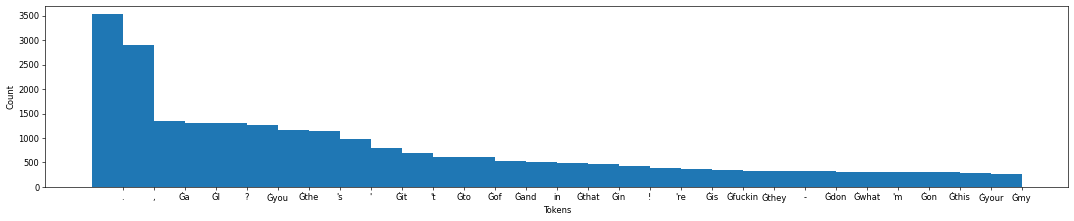

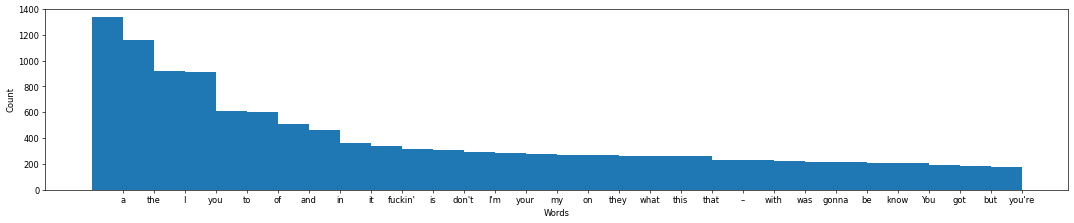

In [17]:
plot_counts(tok_cnt, 'Tokens', top_k = 30)
plot_counts(word_cnt,  'Words', top_k = 30)

### Length distribution

We also show the lenght distribution of the texts:

In [18]:
#collapse
def plot_hist(lens, mean, median, stdev, percentile, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    # plt.text('Mean: %s, Median: %s, Standard Deviation: %s, 90th Percentile: %s', 
    #           str(mean), str(median), str(stdev), str(percentile))
    plt.xlabel('Tokens')
    plt.ylabel('Sentences')
    plt.text(180, 50, f'Mean: {mean},\nMedian: {median},\nStandard Deviation: {stdev},\n90th Percentile: {percentile}')
    plt.show()

Mean: 130.9097065462754, Median: 107, Standard Deviation: 73.4490987636316, 90th Percentile: 389.0


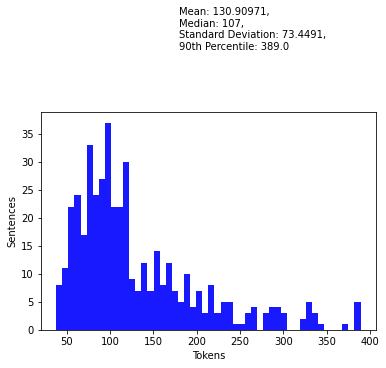

In [19]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens, round(mean(lens), 5), median(lens), round(stdev(lens), 5), np.percentile(lens, 100))

### Tokenization

We tokenize the dataset:

In [20]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

## Loading DialoGPT

In [21]:
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

We define a metric to evaluate the validation dataset:

In [22]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### Defining training loop

We define a function for the training loop of the model:

In [23]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss, train_acc = 0.0, 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)


            logits = outputs.logits
            logits = smax(logits, dim=-1)
            logits = logits.detach().cpu().numpy()

            n_labels = labels.to('cpu').numpy()

            tmp_train_accuracy = flat_accuracy(logits, n_labels)
            print(f'tmp_train_accuracy = {tmp_train_accuracy}')
            train_acc += tmp_train_accuracy



            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step, train_acc / global_step



### Defining function to evaluate

In [24]:
# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0

    ##############################################################################


    eval_loss_buffer = []
    perplexity = 0.0
    perplexity_buffer = []
    tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')


    ##############################################################################

    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)

            lm_loss = outputs[0]
            print(f'Outputs[0]: {outputs[0]}')

            eval_loss += lm_loss.mean().item()

            ############# BLEU SCORE ############



            decoded_inputs = []
            decoded_labels = []

            for input in inputs:
              decoded_input = tokenizer.decode(input, skip_special_tokens=True).split()
              # print(f'DECODED INPUT: {decoded_input}')
              decoded_inputs.append(decoded_input)
            
            for label in labels:
              decoded_output = tokenizer.decode(label, skip_special_tokens=True).split()
              # print(f'DECODED OUTPUT: {decoded_output}')
              decoded_labels.append(decoded_output)

            from nltk.translate.bleu_score import sentence_bleu
            for i in range(0, len(decoded_inputs) - 1):
              decoded_input_list = []
              decoded_input_list.append(decoded_inputs[i])
              print('BLEU score for test-> {}'.format(sentence_bleu(decoded_input_list, decoded_labels[i])))


            if nb_eval_steps > 0:
              eval_loss_buffer.append(eval_loss / nb_eval_steps)
              perplexity = torch.exp(torch.tensor(eval_loss / nb_eval_steps))
              perplexity_buffer.append(perplexity)

              logger.info(" Step: %d, Eval loss: %s, Perplexity: %s", nb_eval_steps, str(eval_loss / nb_eval_steps), str(perplexity))



            #####################################################

        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    eval_loss_buffer.append(eval_loss)
    perplexity_buffer.append(perplexity)

    result = {"perplexity": perplexity, 
              "eval_loss": eval_loss}
    

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

### main function
Now we define the main funtion to train and evaluate the model on a given dataset:

In [25]:
# Main runner

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss, tr_acc = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s, avarage_acc = %s", global_step, tr_loss, tr_acc)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [26]:
%load_ext tensorboard
%tensorboard --logdir runs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 782.

We must check that we have GPU:

In [27]:
!nvidia-smi

Wed Dec 14 20:19:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training the model
Finally, we train the model

In [28]:
main(trn_df, val_df)

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

<ipython-input-22-121b8784b489>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0
tmp_train_accuracy = 0.0


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Outputs[0]: 1.320724606513977
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.2576178312301636
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.7076501846313477
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.0466740131378174
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.1788724660873413
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.05679190158844
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.1940804719924927
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.4267579317092896
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.1847755908966064
BLEU score for test-> 1.0
BLEU score for test-> 1.0
BLEU score for test-> 1.0
Outputs[0]: 1.14418959

{'perplexity_': tensor(3.4875), 'eval_loss_': 1.2491734623908997}

## Using the model

Now, let's chat with the model: 

First, we must load the tokenizer and our model:

In [29]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small', padding_side='left')
model = AutoModelWithLMHead.from_pretrained('output-small')

In [30]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, 
        max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    # pretty print last ouput tokens from bot
    print("Chatbot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Do you like chocolate?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Chatbot: No.
>> User:Do you prefer to eat meat?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Chatbot: I don't like it either.
>> User:so, are you vegetarian?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Chatbot: Yes.
>> User:You need to eat more proteins


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Chatbot: I'm not vegetarian.
>> User:I do not understand


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Chatbot: !!!?!!
